### Setup Environment

In [1]:
Project_Root = '/gdrive/MyDrive/CV_Project/'

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd -q $Project_Root

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
!ls

checkpoints    images	    requirements.txt	train_vqvae.ipynb
data	       models	    residualDataset.py	utils.py
documents      __pycache__  train_hrvae.ipynb	visualization.py
GetData.ipynb  README.md    train_vae.ipynb	visualize.ipynb


In [4]:
!pip install -r requirements.txt --upgrade

### Visualize Data

In [5]:
!ls

checkpoints    images	    requirements.txt	train_vqvae.ipynb
data	       models	    residualDataset.py	utils.py
documents      __pycache__  train_hrvae.ipynb	visualization.py
GetData.ipynb  README.md    train_vae.ipynb	visualize.ipynb


In [6]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [7]:
data_dir = './data'

In [8]:
BATCH_SIZE = 64
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root=data_dir, train=True, download=False, transform=transform)
train_data_variance = torch.Tensor.var(mnist_trainset.data / 255)
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(mnist_trainset))

mnist_testset = datasets.MNIST(root=data_dir, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(len(mnist_testset))

60000
10000


In [9]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Labels:  tensor([8, 0, 9, 9, 3, 3, 6, 6, 2, 1, 9, 2, 2, 5, 1, 9, 6, 7, 0, 6, 2, 0, 3, 2,
        5, 4, 3, 4, 4, 8, 8, 3, 0, 4, 7, 5, 6, 3, 9, 2, 4, 4, 8, 7, 0, 0, 8, 7,
        7, 1, 7, 9, 4, 6, 8, 3, 6, 7, 6, 1, 8, 4, 3, 8])
Batch shape:  torch.Size([64, 1, 32, 32])


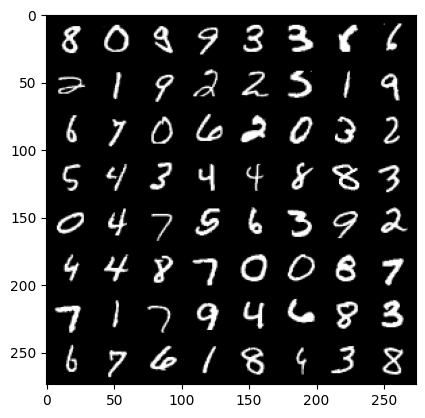

In [10]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

### Hyperparameters

In [11]:
!ls

checkpoints    images	    requirements.txt	train_vqvae.ipynb
data	       models	    residualDataset.py	utils.py
documents      __pycache__  train_hrvae.ipynb	visualization.py
GetData.ipynb  README.md    train_vae.ipynb	visualize.ipynb


In [12]:
from models.vae import VanillaVAE, kld_loss
from utils import load_weights
from torch import nn, optim
import os
import utils

In [13]:
device = torch.device("cuda:0")
epochs = 10
eval_every = 100
save_every = 5
if not os.path.isdir("checkpoints"):
    os.makedirs("checkpoints")
save_path = "checkpoints/vae_save1.pth"
resume_train = os.path.isfile(save_path)
lr = 3e-4
model_args = {
    "in_channels": 1,
    "latent_dim": 128
}

In [14]:
# Load weights if applicable
if resume_train:
  lr, epoch, model_w, optimizer_w, model_args = load_weights(save_path, map_location=device)

# Initialize model.
in_channels, latent_dim = model_args["in_channels"], model_args["latent_dim"]
model = VanillaVAE(in_channels, latent_dim).to(device)
train_params = [params for params in model.parameters()]
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

if resume_train:
  optimizer = optim.Adam(train_params, lr=lr)
  model.load_state_dict(model_w)
  optimizer.load_state_dict(optimizer_w)

### Training VAE

In [15]:
def trainVAE(epoch, model, criterion, optimizer, trainloader, testloader, variance, save_path, device):
  best_train_loss = float("inf")
  for epoch in range(epochs):
      model.train()
      total_train_loss = 0
      total_recon_error = 0
      n_train = 0
      for (batch_idx, train_tensors) in enumerate(trainloader):
          optimizer.zero_grad()
          imgs = train_tensors[0].to(device)
          recon, _, mu, logvar = model(imgs)
          recon_error = criterion(recon, imgs) / variance
          total_recon_error += recon_error.item()
          loss = recon_error + kld_loss(mu, logvar)
          total_train_loss += loss.item()
          loss.backward()
          optimizer.step()
          n_train += 1

          if ((batch_idx + 1) % eval_every) == 0:
              print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
              total_train_loss /= n_train
              if total_train_loss < best_train_loss:
                  best_train_loss = total_train_loss
                  save_dict = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr': lr,
                    'model_args': model_args
                  }
                  ssplit = os.path.splitext(save_path)
                  be_save = f"{ssplit[0]}_best{ssplit[1]}"
                  torch.save(save_dict, be_save)

              print(f"total_train_loss: {total_train_loss} | best_train_loss: {best_train_loss} | recon_error: {total_recon_error / n_train}\n")

              total_train_loss = 0
              total_recon_error = 0
              n_train = 0

      if(epoch % save_every == 0):
          save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': lr,
            'model_args': model_args
          }
          ssplit = os.path.splitext(save_path)
          ep_save = f"{ssplit[0]}_{epoch}{ssplit[1]}"
          torch.save(save_dict, ep_save)

      # Evaluation
      model.eval()
      total_test_loss = 0
      total_test_recon_error = 0
      n_test = 0
      for (batch_idx, test_tensors) in enumerate(testloader):
          imgs = test_tensors[0].to(device)
          recon, _, mu, logvar = model(imgs)
          recon_error = criterion(recon, imgs) / variance
          total_test_recon_error += recon_error.item()
          loss = recon_error + kld_loss(mu, logvar)
          total_test_loss += loss.item()
          n_test += 1

      print(f" total_test_loss: {total_test_loss} | recon_error: {total_test_recon_error / n_test}\n")


In [16]:
trainVAE(epochs, model, criterion, optimizer, trainloader, testloader, train_data_variance, save_path, device)

epoch: 0
batch_idx: 100
total_train_loss: 0.6219634577631951 | best_train_loss: 0.6219634577631951 | recon_error: 0.6002308279275894

epoch: 0
batch_idx: 200
total_train_loss: 0.27734915882349015 | best_train_loss: 0.27734915882349015 | recon_error: 0.25178356140851976

epoch: 0
batch_idx: 300
total_train_loss: 0.1970763324201107 | best_train_loss: 0.1970763324201107 | recon_error: 0.1668615996837616

epoch: 0
batch_idx: 400
total_train_loss: 0.16208885505795478 | best_train_loss: 0.16208885505795478 | recon_error: 0.13042442351579667

epoch: 0
batch_idx: 500
total_train_loss: 0.14195243537425994 | best_train_loss: 0.14195243537425994 | recon_error: 0.1097385548055172

epoch: 0
batch_idx: 600
total_train_loss: 0.12820513799786568 | best_train_loss: 0.12820513799786568 | recon_error: 0.09578082203865051

epoch: 0
batch_idx: 700
total_train_loss: 0.12182271242141723 | best_train_loss: 0.12182271242141723 | recon_error: 0.08910963594913483

epoch: 0
batch_idx: 800
total_train_loss: 0.1124

### Evaluation

In [17]:
!ls

checkpoints    images	    requirements.txt	train_vqvae.ipynb
data	       models	    residualDataset.py	utils.py
documents      __pycache__  train_hrvae.ipynb	visualization.py
GetData.ipynb  README.md    train_vae.ipynb	visualize.ipynb


In [20]:
from utils import save_img_tensors_as_grid

image_save_path = "images/"
if not os.path.isdir(image_save_path):
    os.makedirs(image_save_path)

true_file = os.path.join(image_save_path, "vae_true.png")
recon_file = os.path.join(image_save_path, "vae_recon.png")

model.eval()
with torch.no_grad():
    for valid_tensors in testloader:
        break

    save_img_tensors_as_grid(valid_tensors[0], 4, true_file)
    recon, _, _, _ = model(valid_tensors[0].to(device))
    save_img_tensors_as_grid(recon, 4, recon_file)